# Recommendation System Project: IBM Community

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [294]:
import pandas
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import seaborn as sns


In [295]:
# load data
df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [296]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [297]:
print(f"Number of Null email values is: ")

Number of Null email values is: 


In [298]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might eventually become obsolete),NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and notebooks in dsx,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excluding unnecessary details,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [299]:
# Fill email NaNs with "unknown_user"
df.loc[df['email'].isna(), 'email'] = 'unknown_user'

In [300]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [301]:
# What are the descriptive statistics of the number of articles a user interacts with?
df_user_articles = df.groupby('email')['article_id'].count().reset_index()
df_user_articles.columns = ['email', 'article_count']
df_user_articles["article_count"].describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_count, dtype: float64

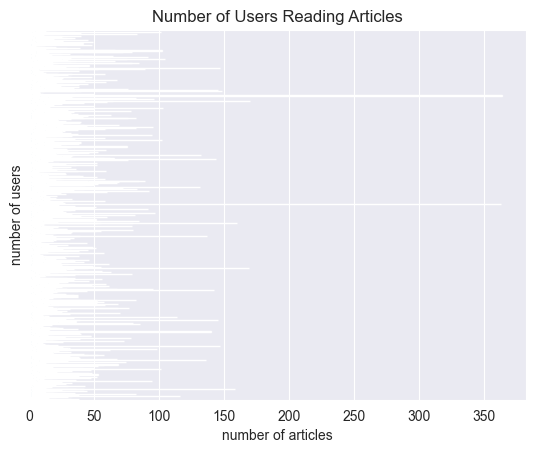

In [302]:
# Create a plot of the number of articles read by each user
sns.barplot(data=df_user_articles, x='article_count', y='email')
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.yticks([])
plt.title('Number of Users Reading Articles')
plt.show()

In [303]:
article_counts = df.groupby('article_id')['email'].count().reset_index()
article_counts.columns = ['article_id', 'read_count']
article_counts['read_count'].describe()

count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: read_count, dtype: float64

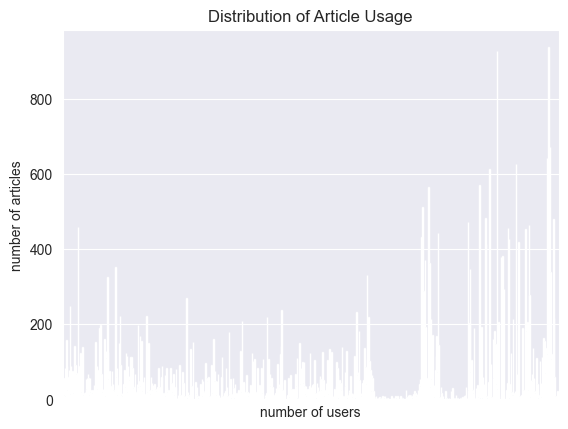

In [304]:
# Create a plot of the number of times each article was read

sns.barplot(data=article_counts, y='read_count', x='article_id')
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.xticks([])
plt.title('Distribution of Article Usage')
plt.show()

In [305]:
# Fill in the median and maximum number of user_article interactions below

median_val = np.median(df_user_articles["article_count"]) # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user =  np.max(df_user_articles["article_count"])# The maximum number of user-article interactions by any 1 user is 364.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [306]:
unique_articles = len(article_counts[article_counts["read_count"] >= 1])
 # The number of unique articles that have at least one interaction
total_articles = len(df["article_id"].unique()) # The number of unique articles on the IBM platform
unique_users =  len(df["email"].unique()) # The number of unique users
user_article_interactions = sum(article_counts["read_count"]) # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [307]:
most_viewed_article_id =  article_counts.loc[article_counts["read_count"].idxmax(), "article_id"]# The most viewed article in the dataset as a string with one value following the decimal 
max_views =  article_counts["read_count"].max()# The most viewed article in the dataset was viewed how many times?

In [308]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [309]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [310]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_articles = df.groupby('article_id')['user_id'].count().reset_index()
    top_articles = top_articles.sort_values(by="user_id", ascending= False)
    top_articles = top_articles["article_id"].iloc[0:n]
    top_articles = df[df["article_id"].isin(top_articles)]["title"].unique().tolist()
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    """
    top_articles = df.groupby('article_id')['user_id'].count().reset_index()
    top_articles = top_articles.sort_values(by="user_id", ascending= False)
    top_articles = top_articles["article_id"].iloc[0:n].tolist()
 
    return top_articles # Return the top article ids

In [311]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [312]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [313]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    
    # convert to string to ensure correct column renaming
   
    data = df.copy()
    data['article_id'] = data['article_id'].astype(str)
    
    unique_article_ids = data['article_id'].unique()

    # pivot data
    user_item = data[data['article_id'].isin(unique_article_ids)].pivot_table(
        index='user_id', 
        columns='article_id', 
        aggfunc='size',  # Count occurrences of interactions
        fill_value=0
    )

    # ensure that pivoted table is binary 
    user_item[user_item >= 1] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [314]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [315]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [316]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    
    # initialize user to be tested
    user_id -=1 # correct for 0 indexing in python 
    user1 = user_item.iloc[user_id].values.reshape(1, -1)
    row_ids = range(len(user_item))
    user_ids = range(1, len(user_item)+1) # user_ids start with 1
    similarity = []
    
    # iterate across user rows and calculate cosine similarity
    for row in row_ids:
        user2 = user_item.iloc[row].values.reshape(1, -1)
        sim = cosine_similarity(user1, user2)
        similarity.append(sim[0][0])

    # store similarity next to user_id
    sim_df = pd.DataFrame({"similarity": similarity,
                           "user_id": user_ids})
    # remove the own user's id
    sim_df = sim_df.drop(user_id)
    
    # sort by similarity
    sim_df = sim_df.sort_values(by=["similarity"], ascending= False)
    
    # create list of just the ids
    ids = sim_df["user_id"].tolist()
    # create list of just the similarities
    sim = sim_df["similarity"].tolist()
    
    if include_similarity:
        return  ids, sim
    return ids # return a list of the users in order from most to least similar
        

In [317]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 46, 4201, 253, 824, 5034, 5041, 136, 2305, 395]
The 5 most similar users to user 3933 are: [1, 4201, 46, 253, 5034]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [318]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    
    article_names = df.loc[df['article_id'].isin(article_ids), "title"].unique()
    
    
    return article_names # Return the article names associated with list of article ids

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    article_ids_str = list(map(str, article_ids))
    rauc = pd.DataFrame({"article_id": article_ids,
                     "interactions": user_item[article_ids_str].sum()})
    rauc = rauc.sort_values(by="interactions", ascending= False)

    ranked_article_unique_counts = rauc[["article_id", "interactions"]].values.tolist()
    
    return ranked_article_unique_counts


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    
    user = user_item.iloc[user_id-1]

    article_ids = user[user == 1].index.tolist()
    
    article_ids = list(map(int, article_ids))

    article_names = get_article_names(article_ids)
    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    
    similar_users, similar_score = find_similar_users(user_id, include_similarity=True)
    recs = [] # initalize recs
    user = user_item.iloc[user_id] # initialize user

    for u in range(0,len(similar_users)):
        id = similar_users[u]
        sim_user = user_item.iloc[id]
        result = user_item.columns[(sim_user == 1) & (user == 0)].tolist()
        
        recs.extend([item for item in result if item not in recs])
        
        # Check if we have enough recommendations
        n_recs = len(recs)
        if n_recs >= m:
            break  # Exit loop if we have enough recommendations
    
        recs = recs[:m]
    
    recs = list(map(int, recs))  
    
    return recs # return your recommendations for this user_id    

In [319]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['classify tumors with machine learning',
       'housing (2015): united states demographic measures',
       'access db2 warehouse on cloud and db2 with python',
       'analyze energy consumption in buildings',
       'pixieapp for outlier detection', 'analyze precipitation data',
       '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
       'analyze traffic data from the city of san francisco',
       'use spark for scala to load data and run sql queries',
       'uci: car evaluation',
       'learn basics about notebooks and apache spark',
       'analyze db2 warehouse on cloud data in rstudio in dsx',
       'customer demographics and sales', 'word2vec in data products',
       'using machine learning to predict value of homes on airbnb',
       'i am not a data scientist – ibm watson data lab',
       'hurricane how-to', 'automating web analytics through python',
       '3 scenarios for machine learning on multicloud',
       'collect

In [320]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [321]:
get_article_names([1024, 1176, 1305, 1314, 1422, 1427])

array(['healthcare python streaming application demo',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'gosales transactions for naive bayes model',
       'use r dataframes & ibm watson natural language understanding',
       'build a python app on the streaming analytics service',
       'using deep learning to reconstruct high-resolution audio'],
      dtype=object)

In [322]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [323]:
user_id = 2
user_ids, sim = find_similar_users(user_id, include_similarity=True)

neighbors_df = pd.DataFrame({'neighbor_id':user_ids,
                                     'similarity':sim})



In [324]:
num_interactions = []
for row in range(len(neighbors_df)):
    id = int(neighbors_df.iloc[row]['neighbor_id'])-1 # correct id for 0 start 
    num_interactions.append(user_item.iloc[id].sum())
    
neighbors_df["num_interactions"] = num_interactions

In [325]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
     
    """
    user_ids, sim = find_similar_users(user_id, include_similarity=True)

    neighbors_df = pd.DataFrame({'neighbor_id':user_ids,
                                     'similarity':sim})
    num_interactions = []
    for row in range(len(neighbors_df)):
        id = int(neighbors_df.iloc[row]['neighbor_id'])-1
        num_interactions.append(user_item.iloc[id].sum())
    
    neighbors_df["num_interactions"] = num_interactions

    neighbors_df.sort_values(by=["similarity",'num_interactions'], ascending=False, inplace=True, ignore_index=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [326]:
def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    top_sorted_users = get_top_sorted_users(user_id)
    recs = [] # initalize recs
    user = user_item.iloc[user_id] # initialize user

    for u in range(0,len(top_sorted_users)):
        id = top_sorted_users["neighbor_id"][u]
        sim_user = user_item.iloc[id]
        result = user_item.columns[(sim_user == 1) & (user == 0)].tolist()
            
        recs.extend([item for item in result if item not in recs])
            
        # Check if we have enough recommendations
        n_recs = len(recs)
        if n_recs >= m:
            break  # Exit loop if we have enough recommendations
        
    recs = recs[:m]
    recs = list(map(int, recs))

    # sort articles by most total interaction 
    recs_df = df[df["article_id"].isin(recs)]
    recs_df = recs_df.groupby("article_id")["user_id"].count().reset_index()
    recs_df.columns = ["article_id", "count"]
    recs_df = recs_df.sort_values(by="count", ascending=False).reset_index(drop=True)

    recs = recs_df["article_id"].tolist()
    
    return recs, get_article_names(recs) # return your recommendations for this user_id

In [327]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1398, 1282, 1424, 682, 1059, 911, 1286, 113, 522, 1146]

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: amsterdam calendar'
 'using machine learning to predict baseball injuries'
 'total population by country'
 'easy json loading and social sharing in dsx notebooks'
 'use spark for python to load data and run sql queries'
 'employed population by occupation and age'
 'environment statistics database - water'
 'this week in data science (february 28, 2017)'
 'airbnb data for analytics: trentino reviews'
 'share the (pixiedust) magic – ibm watson data lab – medium']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [328]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
   neighbor_id  similarity  num_interactions
0         5083    0.730297                 5
1         1552    0.577350                 2
2         1890    0.577350                 2
3         1372    0.471405                 3
4         2941    0.433013                 8
5         3586    0.408248                 4
6         2595    0.408248                 1
7          331    0.408248                 1
8         2597    0.408248                 1
9          701    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1         4459    0.388909                96
2          203    0.388909                96
3         3782    0.387585               135
4         4932    0.384308                52
5           40    0.384308                52
6           23    0.377647               135
7          242    0.375823                59
8         

In [329]:
### Tests with a dictionary of results
user1_most_sim =  get_top_sorted_users(1)["neighbor_id"][0]# Find the user that is most similar to user 1 
user2_6th_sim =  get_top_sorted_users(2)["neighbor_id"][5]# Find the 6th most similar user to user 2
user131_10th_sim =  get_top_sorted_users(131)["neighbor_id"][9]# Find the 10th most similar user to user 131

In [330]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

If no user history is available, we can not use a recommendation based on user similarity. Therefore, we could only recommend articles based on how many interactions they have: *get_top_articles*

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [331]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)


In [332]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [333]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [334]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [335]:
# unique articles
df_unique_articles = df.drop_duplicates(subset=["article_id"], keep="first")

In [336]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles["title"]) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)# Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

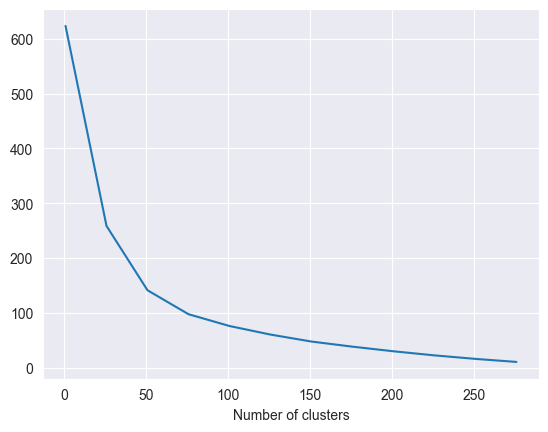

In [337]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [338]:
n_clusters = 50
kmeans = KMeans(
        n_clusters=n_clusters,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
).fit(X_lsa)

In [339]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df

pred_cluster = kmeans.predict(X_lsa)
article_cluster_map = dict(zip(df_unique_articles['article_id'], pred_cluster))

df['title_cluster'] = df['article_id'].map(article_cluster_map)# apply map to create title clusters

In [340]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 23],
       [ 1, 10],
       [ 2, 65],
       [ 3, 10],
       [ 4, 32],
       [ 5,  9],
       [ 6, 23],
       [ 7, 31],
       [ 8, 16],
       [ 9, 15],
       [10, 37],
       [11, 20],
       [12, 16],
       [13, 10],
       [14, 14],
       [15, 28],
       [16,  9],
       [17,  4],
       [18, 11],
       [19, 20],
       [20,  7],
       [21, 13],
       [22,  8],
       [23,  7],
       [24, 11],
       [25, 22],
       [26, 10],
       [27,  8],
       [28, 11],
       [29,  8],
       [30, 11],
       [31,  9],
       [32, 12],
       [33,  7],
       [34, 19],
       [35,  8],
       [36,  7],
       [37,  8],
       [38,  9],
       [39, 10],
       [40, 11],
       [41, 11],
       [42, 11],
       [43,  9],
       [44, 19],
       [45,  9],
       [46,  6],
       [47,  3],
       [48,  5],
       [49, 22]])

In [341]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
     # Your code here
    title_cluster = df.loc[df["article_id"] == article_id, "title_cluster"].values[0]
    articles_in_cluster = df[df["title_cluster"]==title_cluster]

    # remove the input article_id from the list
    articles_in_cluster = articles_in_cluster[articles_in_cluster["article_id"] != article_id]
        
    articles_in_cluster = articles_in_cluster["article_id"].unique().tolist()
    
    return articles_in_cluster

In [342]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    similar_articles = get_similar_articles(article_id)
    
    n_ranked_similar_articles = get_ranked_article_unique_counts(similar_articles)[:n]
    n_ranked_similar_articles = [sublist[0] for sublist in n_ranked_similar_articles]
    
    n_ranked_article_names = get_article_names(n_ranked_similar_articles)
    
    return n_ranked_similar_articles, n_ranked_article_names
        

In [343]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 101, 975, 766, 508, 547, 132, 878, 92, 693]
['better together: spss and data science experience'
 'data science in the cloud' 'collecting data science cheat sheets'
 'making data science a team sport'
 'how to choose a project to practice data science'
 'data tidying in data science experience' 'trust in data science'
 'the data science process'
 '10 data science podcasts you need to be listening to right now'
 '9 mistakes to avoid when starting your career in data science']


In [344]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Answer:**

The content-based recommendation system works by extracting information from article titles using natural language processing (TF-IDF). A vocabulary of 125 terms is extracted and used to cluster the titles into 50 distinct clusters. The number of clusters was determined by analyzing the elbow point of the scree plot. 

When recommending articles, those that belong to the same cluster as the provided article are suggested, with higher-ranked articles being prioritized. 

To improve the content-based recommendation system, it would be beneficial to include additional information beyond just the title. Specifically, the article text data would provide deeper insights into the full article content. Additionally, metadata such as the publication date and author could further enhance the clustering process, by including factors like recency and authorship, allowing the system to make more relevant and timely recommendations.


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [345]:
# quick look at the matrix
user_item.head()

article_id,0,100,1000,1004,1006,1008,101,1014,1015,1016,...,977,98,981,984,985,986,990,993,996,997
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [346]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

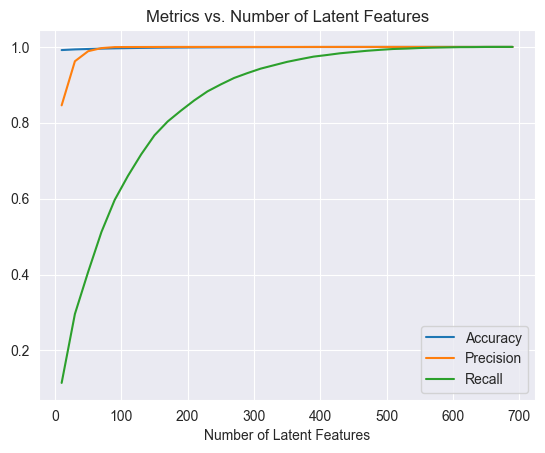

In [347]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Answer:**

I would select the number of latent features at the elbow point which occurs around 200 latent features. While increasing the number of latent features improves recall, it could also make the model overly complex. It is important to find a balance between computational complexity and model performance, especially since the improvements stagnate after the elbow point.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [348]:
article_id = 100
article_id = str(article_id)
article_idx= user_item.columns.tolist().index(article_id)
vt = v
cos_sim = cosine_similarity(vt.T)

article_sim = pd.DataFrame({"sim": cos_sim[article_idx],
                            "article_id": user_item.columns.values
                            })
article_sim = article_sim.drop(article_idx)

article_sim.sort_values(by="sim", ascending=False, inplace=True, ignore_index=True)

similar_article_id = article_sim["article_id"]
similarity = article_sim["sim"]


In [349]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    article_id = str(article_id)
    article_idx= user_item.columns.tolist().index(article_id)
    # Find the cosine similarity of all articles
    cos_sim = cosine_similarity(vt.T)
    # Get similarities only for the cos_sim of the article_idx
    article_sim = pd.DataFrame({"sim": cos_sim[article_idx],
                            "article_id": user_item.columns.values
                            })
    
    article_sim = article_sim.drop(article_idx)
    # Sort and return the articles, don't include the own article
    article_sim.sort_values(by="sim", ascending=False, inplace=True, ignore_index=True)
     
    similar_article_id = article_sim["article_id"].astype(int)
    similarity = article_sim["sim"]
    
    if include_similarity:
        return [[similar_article_id, similarity]]
    return similar_article_id.tolist()

In [350]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [351]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [352]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [353]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

array(['use spark r to load and analyze data',
       'collecting data science cheat sheets',
       '10 powerful features on watson data platform, no coding necessary',
       'notebooks: a power tool for data scientists',
       'country statistics: crude oil - proved reserves',
       'country statistics: crude oil - exports',
       'top analytics tools in 2016',
       'advancements in the spark community',
       'airbnb data for analytics: paris calendar',
       'airbnb data for analytics: athens reviews'], dtype=object)

In [354]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


In [355]:
make_content_recs(article_id=4, n=10)

([1160, 1165, 1163, 1164, 865, 202, 131, 189, 1161, 708],
 array(['common excel tasks demonstrated in\xa0pandas',
        'analyze open data sets with pandas dataframes',
        'analyze open data sets with spark & pixiedust',
        'simple graphing with ipython and\xa0pandas',
        'analyze precipitation data',
        'analyze accident reports on amazon emr spark',
        'analyze traffic data from the city of san francisco',
        'analyze open data sets using pandas in a python notebook',
        'analyze data, build a dashboard with spark and pixiedust',
        'load and analyze public data sets in dsx'], dtype=object))

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Answer:**

Each recommendation model has its strengths and limitations. While rank-based models do not provide personalized recommendations, they can work well for new users without prior history. For example, they are useful for a homepage showcasing the most frequently interacted-with articles. However, this approach tends to favor popular articles, making it less effective for newer or niche articles.

User-user based collaborative filtering provides personalized recommendations based on similar users' preferences. This makes it ideal for sections that suggest articles liked by others with similar interests. However, since it does not consider article content, recommendations may not always be thematically relevant. Additionally, this method required user history and is computationally intensive due to pairwise similarity calculations.

In contrast, content-based recommendations suggest articles based on their content. This approach is useful for recommending articles closely related to the one a user is currently reading. It also works well for new users, as it does not rely on user history. However, it may limit diversity, as it tends to recommend articles within the same topic range. 

Matrix-factorization provide recommendations based on hidden latent factors. This model is effective with sparse data and can, therefore, be used in situations where only little user history is available. However, this model lacks interpretability, making it difficult to explain why a particular article was recommended and what the hidden latent factors represent. 

To evaluate the effectivenss of these models, A/B testing can be implemented. Key metrics such as conversion rate, click-trough rate, and user engagement can help determine performance. Additionally, interleaved testing (presenting two recommendation models simultaneously) can be used to directly compare two models and evaluate which recommendations where preferred. 

Finally, since each model produces different recommendations, combining them may improve overall performance. For example, content-based recommendations for *article_id 4* focus primarily on the analytics aspect of the article title, while matrix factorization suggests a more diverse set of articles. A hybrid approach, blending content-based filtering for relevance with matrix factorization for diversity, could enhance recommendation quality by balancing specificity with broader exploration. The hybrid approach would of course need to be properly tested. 


In [356]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', '--to html', 'Recommendations_with_IBM.ipynb'])